In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import r2_score
from math import exp,log,sqrt
from gplearn.genetic import SymbolicRegressor
# Measured pig stem cell dry mass: 352.24 pg/cell
#Single CHO cell dry mass: 280 pg/cell. Ref:https://doi.org/10.1016/j.ymben.2021.03.013
#Single mammalian cell dry mass: 264pg/cell. Ref: https://doi.org/10.1016/j.ymben.2020.06.002 

In [2]:
def add_linear(ax, xdata, ydata, color):
    def func(x, a, b):
        return a * x + b
    popt, pcov = curve_fit(func, xdata, ydata)
    temp_x = np.linspace(min(xdata),max(xdata) )
    ax.plot(temp_x, func(temp_x, *popt),c=color)
    
def get_pv(x,y):
    coeff, pv = stats.pearsonr( x, y)
    return pv

def get_pcc(x,y):
    coeff, pv = stats.pearsonr( x, y)
    return coeff

In [3]:
data_low=pd.read_csv('../data/exp_data/CultureData_lowNH4.csv')
data_low=data_low.rename(columns={'Biomass_avg(g/L)':'Biomass_avg','Biomass_std(g/L)':'Biomass_std'})
data_high=pd.read_csv('../data/exp_data/CultureData_highNH4.csv')
data_high=data_high.rename(columns={'Biomass_avg(g/L)':'Biomass_avg','Biomass_std(g/L)':'Biomass_std'})

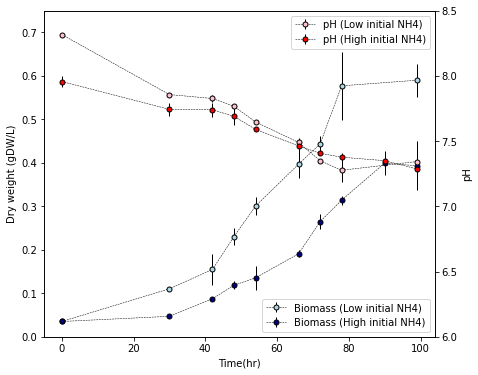

In [4]:
fig,ax=plt.subplots(1,1,figsize=(7,6))
ax1=ax.twinx()
ax.errorbar(data_low.Time,data_low.Biomass_avg,yerr= data_low.Biomass_std, color='black',ecolor='black',markerfacecolor='lightblue',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Biomass (Low initial NH4)')
ax.errorbar(data_high.Time,data_high.Biomass_avg,yerr= data_high.Biomass_std, color='black', ecolor='black', markerfacecolor='navy',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Biomass (High initial NH4)')
ax.set_ylabel('Dry weight (gDW/L)')
ax1.errorbar(data_low.Time,data_low.pH_avg,yerr= data_low.pH_std, color='black',markerfacecolor='pink',ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='pH (Low initial NH4)')
ax1.errorbar(data_high.Time, data_high.pH_avg,yerr= data_high.pH_std, color='black',markerfacecolor='red',ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='pH (High initial NH4)')
ax.set_ylim([0,0.75])
ax1.set_ylim([6,8.5])
ax1.set_ylabel('pH')
ax.set_xlabel('Time(hr)')
ax.legend(loc='lower right')
ax1.legend(loc='upper right')

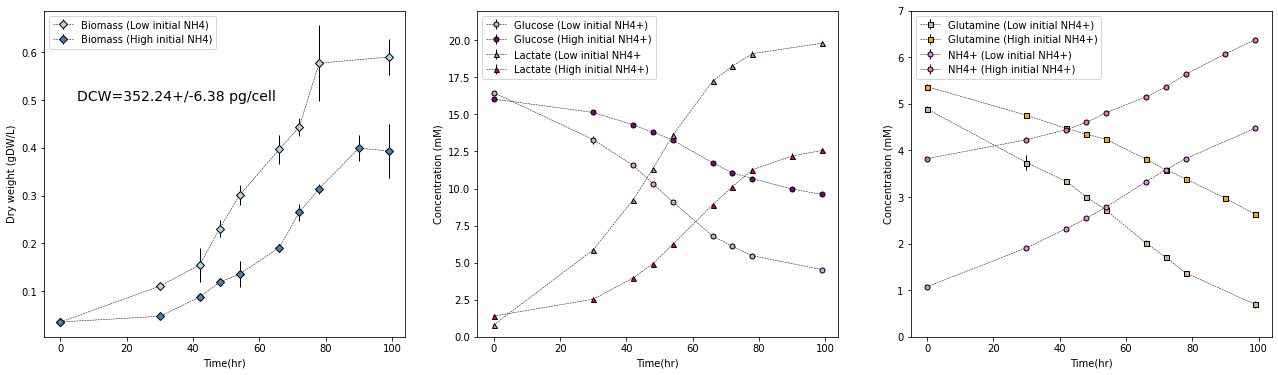

In [10]:
fig, axs = plt.subplots(1,3,figsize=(22,6))
axs[0].errorbar(data_low.Time,data_low.Biomass_avg,yerr= data_low.Biomass_std, color='black',markerfacecolor='lightblue',ecolor='black',
                      marker='D', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Biomass (Low initial NH4)')
axs[0].errorbar(data_high.Time,data_high.Biomass_avg,yerr= data_high.Biomass_std, color='black',markerfacecolor='steelblue', ecolor='black',
                      marker='D', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Biomass (High initial NH4)')
axs[0].set_ylabel('Dry weight (gDW/L)')
axs[0].legend()
axs[0].text(5,0.5,s='DCW=352.24+/-6.38 pg/cell',fontsize=14)

axs[1].errorbar(data_low.Time,data_low['Glucose_avg'],yerr= data_low['Glucose_std'], color='black',markerfacecolor='plum',ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Glucose (Low initial NH4+)')
axs[1].errorbar(data_high.Time,data_high['Glucose_avg'],yerr= data_high['Glucose_std'], color='black',markerfacecolor='purple',ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Glucose (High initial NH4+)')
axs[1].errorbar(data_low.Time,data_low['Lac_avg'],yerr= data_low['Lac_std'],  color='black',markerfacecolor='salmon',ecolor='black',
                      marker='^', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Lactate (Low initial NH4+')
axs[1].errorbar(data_high.Time,data_high['Lac_avg'],yerr= data_high['Lac_std'],  color='black',markerfacecolor='red',ecolor='black',
                      marker='^', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Lactate (High initial NH4+)')

axs[2].errorbar(data_low.Time,data_low['Gln_avg'],yerr= data_low['Gln_std'], color='black',markerfacecolor='tan',ecolor='black',
                      marker='s', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Glutamine (Low initial NH4+)')
axs[2].errorbar(data_high.Time,data_high['Gln_avg'],yerr= data_high['Gln_std'],color='black',markerfacecolor='orange',ecolor='black',
                      marker='s', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='Glutamine (High initial NH4+)')
axs[2].errorbar(data_low.Time,data_low['NH4_avg'],yerr= data_low['NH4_std'],color='black',markerfacecolor='violet',ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='NH4+ (Low initial NH4+)')
axs[2].errorbar(data_high.Time,data_high['NH4_avg'],yerr= data_high['NH4_std'],color='black',markerfacecolor='hotpink',ecolor='black',
                      marker='o', markersize=5, linestyle='--', linewidth=0.5, elinewidth=1,label='NH4+ (High initial NH4+)')
for ax in axs:
    ax.set_xlabel('Time(hr)')
    ax.legend(loc='upper left')
axs[1].set_ylabel('Concentration (mM)')
axs[2].set_ylabel('Concentration (mM)')
axs[1].set_ylim([0,22.0]);
axs[2].set_ylim([0,7.0]);
# plt.savefig('../../Figures/culture_data.svg',format='svg',dpi=150)

In [4]:
def get_grs(biomass, time_pts):
    output = []
    for i in range(len(biomass)-1):
        output.append( np.log(biomass[i+1]/biomass[i]) /(time_pts[i+1]-time_pts[i]) )
    return output  
def avg_cons(cons):
    output = []
    for i in range(len(cons)-1):
        output.append( (cons[i+1]+cons[i])/2 )
    return output
def norm_rates(biomass, cons, time_pts):
    output = []
    for i in range(len(biomass)-1):
        output.append( ((cons[i+1]-cons[i])/(biomass[i]/2+biomass[i+1]/2) )/(time_pts[i+1]-time_pts[i]) )
    return output

In [5]:
mets=['Glucose','Gln','Lac','NH4']
Ts= [data_low.Time[i]/2+data_low.Time[i+1]/2 for i in range(len(data_low.Time)-1)]
T_interval = [ str(data_low.Time[i])+'hr'+'~'+str(data_low.Time[i+1])+'hr' for i in range(len(data_low.Time)-1) ]
grs=get_grs(data_low.Biomass_avg, data_low.Time)
approx_low = pd.DataFrame(zip(T_interval,Ts,grs),columns=['Interval','Time','gr'])
for met in mets:
    approx_low[met+'_rate']=norm_rates( data_low.Biomass_avg, data_low[met+'_avg'], data_low.Time)
    approx_low[met+'_conc']=avg_cons( data_low[met+'_avg'] )
Ts=[data_high.Time[i]/2+data_high.Time[i+1]/2 for i in range(len(data_high.Time)-1)]
T_interval = [ str(data_high.Time[i])+'hr'+'~'+str(data_high.Time[i+1])+'hr' for i in range(len(data_high.Time)-1) ]
grs=get_grs(data_high.Biomass_avg, data_high.Time)
approx_high = pd.DataFrame(zip(T_interval,Ts,grs),columns=['Interval','Time','gr'])
for met in mets:
    approx_high[met+'_rate']=norm_rates( data_high.Biomass_avg, data_high[met+'_avg'], data_high.Time)
    approx_high[met+'_conc']=avg_cons( data_high[met+'_avg'] )

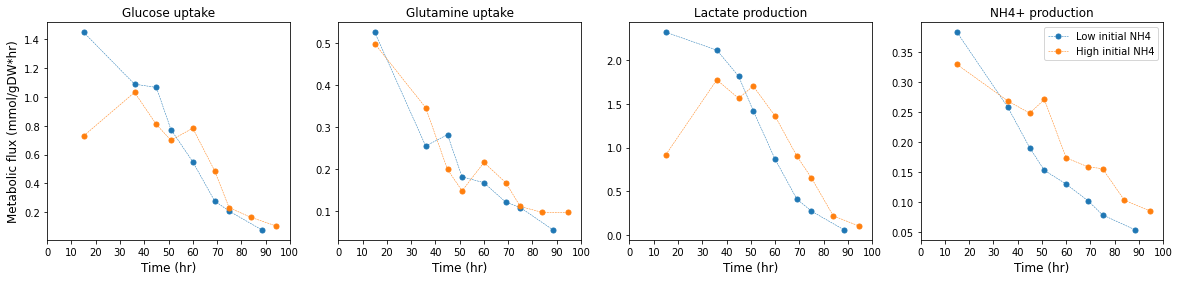

In [13]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
ynames=['Glucose','Gln','Lac','NH4']
for i in range(4):
    if i <2:
        factor=-1
    else:
        factor=1
    axs[i].plot(approx_low.Time, factor*approx_low[ynames[i]+'_rate'],marker='o', markersize=5, 
                linestyle='--', linewidth=0.5,label='Low initial NH4')
    axs[i].plot(approx_high.Time, factor*approx_high[ynames[i]+'_rate'],marker='o', markersize=5, 
                linestyle='--', linewidth=0.5,label='High initial NH4')
    axs[i].set_xlabel('Time (hr)',fontsize=12)
    axs[i].set_xticks(np.arange(0,110,10))
axs[0].set_ylabel('Metabolic flux (mmol/gDW*hr)',fontsize=12)
axs[3].legend(loc='upper right')
axs[0].set_title('Glucose uptake'); axs[1].set_title('Glutamine uptake');
axs[2].set_title('Lactate production'); axs[3].set_title('NH4+ production');

In [10]:
print(get_pcc(approx_low.gr,approx_low.Lac_conc))
print(get_pcc(approx_high.gr,approx_high.Lac_conc))
print(get_pcc(approx_low.gr,approx_low.NH4_conc))
print(get_pcc(approx_high.gr,approx_high.NH4_conc))

-0.4460864129412909
-0.2999150492181718
-0.5132271215155667
-0.382732035050267


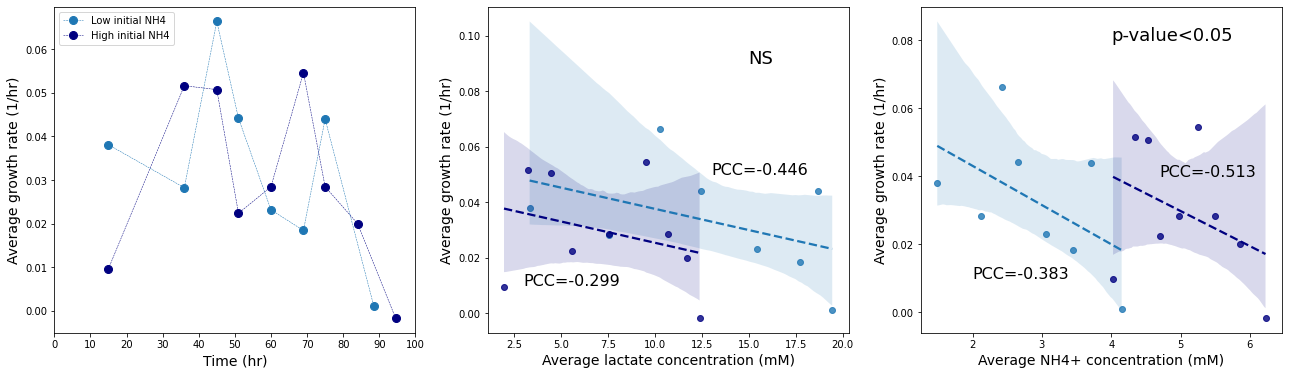

In [15]:
fig, axs = plt.subplots(1,3,figsize=(22,6))
axs[0].plot(approx_low.Time,approx_low.gr,marker='o', color='tab:blue',markersize=8, linestyle='--', 
            linewidth=0.5, label='Low initial NH4')
axs[0].plot(approx_high.Time,approx_high.gr,marker='o', color='navy',markersize=8, linestyle='--', 
            linewidth=0.5,label='High initial NH4')
axs[0].set_ylabel('Average growth rate (1/hr)',fontsize=14); axs[0].set_xlabel('Time (hr)',fontsize=14)
axs[0].legend(loc='upper left')
axs[0].set_xticks(np.arange(0,110,10));

sns.regplot(x = "Lac_conc", y = "gr", color='tab:blue',line_kws={'ls':'--'},data = approx_low,ax=axs[1])
sns.regplot(x = "Lac_conc", y = "gr", color='navy',line_kws={'ls':'--'},data = approx_high,ax=axs[1])
sns.regplot(x = "NH4_conc", y = "gr",color='tab:blue', line_kws={'ls':'--'},data = approx_low,ax=axs[2])
sns.regplot(x = "NH4_conc", y = "gr", color='navy',line_kws={'ls':'--'},data = approx_high,ax=axs[2])
axs[1].set_ylabel('Average growth rate (1/hr)',fontsize=14); axs[1].set_xlabel('Average lactate concentration (mM)',fontsize=14);
axs[1].text(15,0.09,s='NS',fontsize=18)
axs[1].text(13,0.05,s='PCC=-0.446',fontsize=16)
axs[1].text(3,0.01,s='PCC=-0.299',fontsize=16)
axs[2].set_ylabel('Average growth rate (1/hr)',fontsize=14); axs[2].set_xlabel('Average NH4+ concentration (mM)',fontsize=14);
axs[2].text(4,0.08,s='p-value<0.05',fontsize=18)
axs[2].text(4.7,0.04,s='PCC=-0.513',fontsize=16)
axs[2].text(2,0.01,s='PCC=-0.383',fontsize=16)
# plt.savefig('../../Figures/lac_nh4_vs_gr.svg',format='svg',dpi=150)

In [6]:
ATP_approx_low, ATP_approx_high=[],[]
our_approx_low, our_approx_high = [],[]
for i in range(len(approx_low.index)):
    lac_r=approx_low.Lac_rate[i];glc_r=(-1)*approx_low.Glucose_rate[i];gln_r=(-1)*approx_low.Gln_rate[i];
    ATP_approx_low.append( min(lac_r,glc_r*2) + max(0,(glc_r-lac_r/2))*30 + gln_r*12.5 )
    our_approx_low.append( max(0,(glc_r-lac_r/2))*6 + gln_r*6 )
for i in range(len(approx_high.index)):
    lac_r=approx_high.Lac_rate[i];glc_r=(-1)*approx_high.Glucose_rate[i];gln_r=(-1)*approx_high.Gln_rate[i];
    ATP_approx_high.append( min(lac_r,glc_r*2) + max(0,(glc_r-lac_r/2))*30 + gln_r*12.5 )
    our_approx_high.append( max(0,(glc_r-lac_r/2))*6 + gln_r*6 )
    
approx_low['ATP_estimated']=ATP_approx_low
approx_high['ATP_estimated']=ATP_approx_high
approx_low['OUR_estimated']=our_approx_low
approx_high['OUR_estimated']=our_approx_high

In [8]:
# approx_low.to_csv('../data/exp_data/approx_flux_lowNH4.csv',index=None)
# approx_high.to_csv('../data/exp_data/approx_high_lowNH4.csv',index=None)

In [7]:
temp_grs = list(approx_low.gr)[2:]
temp_atp = list(approx_low.ATP_estimated)[2:]
def func(x, a, b):
    return a * x + b
popt, pcov = curve_fit(func, temp_grs, temp_atp)
print(popt)

pred_y = [93.8648*x+2.2771 for x in temp_grs]
print( get_pcc(pred_y,temp_atp) )
print( r2_score(pred_y,temp_atp) )

[93.86484457  2.27706263]
0.7899765693079276
0.3975970405811591


In [8]:
temp_grs = list(approx_high.gr)[1:-1]
temp_atp = list(approx_high.ATP_estimated)[1:-1]
def func(x, a, b):
    return a * x + b
popt, pcov = curve_fit(func, temp_grs, temp_atp)
print(popt)

pred_y = [94.7464*x+1.4926 for x in temp_grs]
print( get_pcc(pred_y,temp_atp) )
print( r2_score(pred_y,temp_atp) )

[94.74638523  1.49255577]
0.4862277546844884
-2.2298054197682013


Text(0.022, 10.4, 'High initial NH4')

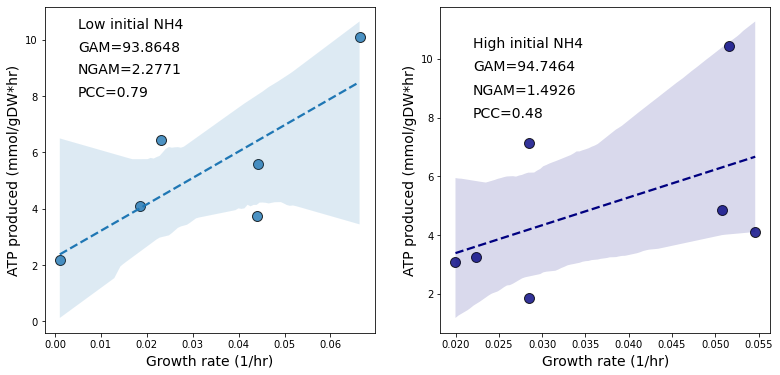

In [10]:
fig,axs=plt.subplots(1,2,figsize=(13,6))
sns.regplot(x='gr',y='ATP_estimated',data=approx_low.iloc[2:],line_kws={'ls':'--'},
            scatter_kws={'s':100,'edgecolor':'black','color':'tab:blue'},ax=axs[0])
axs[0].set_xlabel('Growth rate (1/hr)',fontsize=14);
axs[0].set_ylabel('ATP produced (mmol/gDW*hr)',fontsize=14)
axs[0].text(0.005,8,s='PCC=0.79',fontsize=14)
axs[0].text(0.005,8.8,s='NGAM=2.2771',fontsize=14)
axs[0].text(0.005,9.6,s='GAM=93.8648',fontsize=14)
axs[0].text(0.005,10.4,s='Low initial NH4',fontsize=14)

sns.regplot(x='gr',y='ATP_estimated',data=approx_high.iloc[1:-1],line_kws={'ls':'--','color':'navy'},
            scatter_kws={'s':100,'edgecolor':'black','color':'navy'},ax=axs[1])
axs[1].set_xlabel('Growth rate (1/hr)',fontsize=14);
axs[1].set_ylabel('ATP produced (mmol/gDW*hr)',fontsize=14)
axs[1].text(0.022,8,s='PCC=0.48',fontsize=14)
axs[1].text(0.022,8.8,s='NGAM=1.4926',fontsize=14)
axs[1].text(0.022,9.6,s='GAM=94.7464',fontsize=14)
axs[1].text(0.022,10.4,s='High initial NH4',fontsize=14)
# plt.savefig('../../Figures/GAM_NGAM.svg',format='svg',dpi=150)

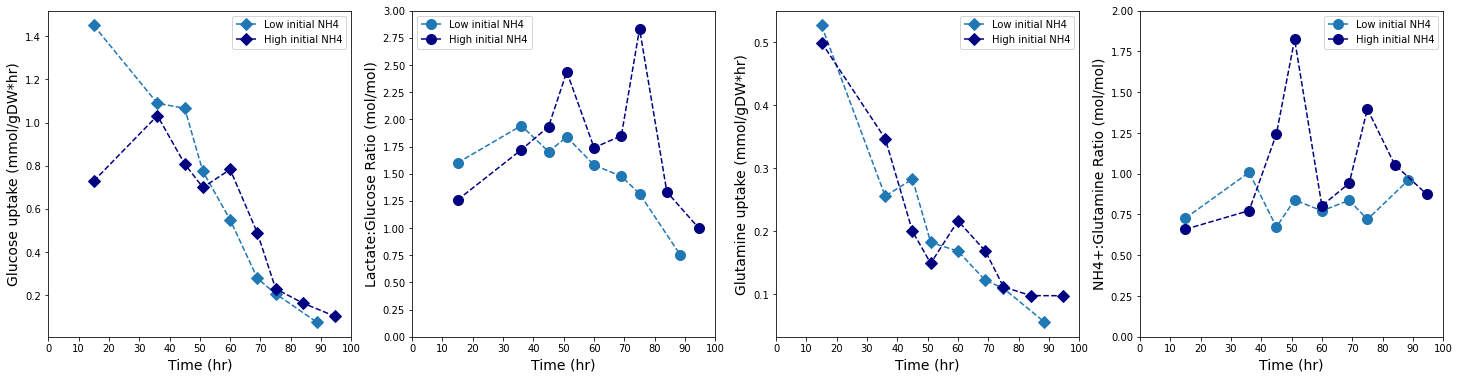

In [24]:
fig,axs=plt.subplots(1,4,figsize=(25,6))
axs[0].plot(approx_low.Time, -1*approx_low.Glucose_rate,marker='D', color='tab:blue',
            markersize=8, linestyle='--',label='Low initial NH4')
axs[0].plot(approx_high.Time, -1*approx_high.Glucose_rate,marker='D', color='navy',
            markersize=8, linestyle='--',label='High initial NH4')
axs[0].legend(); axs[0].set_xlabel('Time (hr)',fontsize=14); axs[0].set_ylabel('Glucose uptake (mmol/gDW*hr)',fontsize=14);
axs[0].set_xticks(np.arange(0,110,10));

axs[1].plot(approx_low.Time,-1*approx_low.Lac_rate/approx_low.Glucose_rate,marker='o', color='tab:blue',
            markersize=10, linestyle='--',label='Low initial NH4')
axs[1].plot(approx_high.Time,-1*approx_high.Lac_rate/approx_high.Glucose_rate,marker='o', color='navy',
            markersize=10, linestyle='--',label='High initial NH4')
axs[1].set_xticks(np.arange(0,105,10)); axs[1].set_yticks(np.arange(0,3.2,0.25));axs[1].legend();
axs[1].set_xlabel('Time (hr)',fontsize=14); axs[1].set_ylabel('Lactate:Glucose Ratio (mol/mol)',fontsize=14);

axs[2].plot(approx_low.Time, -1*approx_low.Gln_rate,marker='D', color='tab:blue',
            markersize=8, linestyle='--',label='Low initial NH4')
axs[2].plot(approx_high.Time, -1*approx_high.Gln_rate,marker='D', color='navy',
            markersize=8, linestyle='--',label='High initial NH4')
axs[2].legend(); axs[2].set_xlabel('Time (hr)',fontsize=14); axs[2].set_ylabel('Glutamine uptake (mmol/gDW*hr)',fontsize=14);
axs[2].set_xticks(np.arange(0,110,10));

axs[3].plot(approx_low.Time,-1*approx_low.NH4_rate/approx_low.Gln_rate,marker='o', color='tab:blue',
            markersize=10, linestyle='--',label='Low initial NH4')
axs[3].plot(approx_high.Time,-1*approx_high.NH4_rate/approx_high.Gln_rate,marker='o', color='navy',
            markersize=10, linestyle='--',label='High initial NH4')
axs[3].set_xticks(np.arange(0,105,10)); axs[3].set_yticks(np.arange(0,2.2,0.25));axs[3].legend();
axs[3].set_xlabel('Time (hr)',fontsize=14); axs[3].set_ylabel('NH4+:Glutamine Ratio (mol/mol)',fontsize=14);
# plt.savefig('../../Figures/Glc_rate_ratio.svg',format='svg',dpi=150)

In [13]:
def lac_inhibit_glc(x, a,b):
    return a*x+b
popt, pcov = curve_fit(lac_inhibit_glc, approx_low.Lac_conc, -1*approx_low.Glucose_rate)
print(popt)

pred_y = [lac_inhibit_glc(x, -0.084,1.789)for x in approx_low.Lac_conc]
print(get_pcc(pred_y,-1*approx_low.Glucose_rate))
print(get_pv(pred_y,-1*approx_low.Glucose_rate))
print(r2_score(pred_y,-1*approx_low.Glucose_rate))

[-0.0840688   1.78896772]
0.9884535587944555
3.815187785904768e-06
0.9764574786452662


In [36]:
def nh4_inhibit_glc(X,k1,k2):
    x1, x2= X
    return lac_inhibit_glc(x1, -0.084,1.789)*k1/(x2+k2)
popt, pcov = curve_fit(nh4_inhibit_glc, (approx_high.Lac_conc[1:], approx_high.NH4_conc[1:]), -1*approx_high.Glucose_rate[1:])
print(popt)

pred_y = [nh4_inhibit_glc( (approx_high.Lac_conc[i],approx_high.NH4_conc[i]),0.9612, -2.9434)
          for i in range(1,len(approx_high.Lac_conc))]
print(get_pcc(pred_y,-1*approx_high.Glucose_rate[1:]))
print(get_pv(pred_y,-1*approx_high.Glucose_rate[1:]))
print(r2_score(pred_y,-1*approx_high.Glucose_rate[1:]))

[ 0.96119295 -2.94339846]
0.941038824992688
0.0004900414519455228
0.8395163947592612


In [31]:
all_glc_rates = list(-1*approx_low.Glucose_rate)+list(-1*approx_high.Glucose_rate)[1:]
all_lac = list(approx_low.Lac_conc)+list(approx_high.Lac_conc)[1:]
all_nh4 = list(approx_low.NH4_conc)+list(approx_high.NH4_conc)[1:]
def inhibit_glc(X, k1,k2,k3,k4):
    x1,x2=X
    return 1.45*(k1/(x1+k2))*(k3/(x2+k4))
popt, pcov = curve_fit(inhibit_glc, (all_lac, all_nh4), all_glc_rates)
print(popt)

pred_y = [inhibit_glc( (all_lac[i],all_nh4[i]),6.1436, 5.9007, 6.0443, 2.0889 )
          for i in range(len(all_nh4))]
print(get_pcc(pred_y,all_glc_rates))
print(get_pv(pred_y,all_glc_rates))
print( r2_score(pred_y,all_glc_rates) )

[6.14362238 5.9006968  6.04433563 2.08891959]
0.903587254375043
1.603920518270295e-06
0.6851491254140771


In [7]:
# # GP approach
# all_glc_rates = list(-1*approx_low.Glucose_rate)+list(-1*approx_high.Glucose_rate)
# all_lac = list(approx_low.Lac_conc)+list(approx_high.Lac_conc)
# all_nh4 = list(approx_low.NH4_conc)+list(approx_high.NH4_conc)
# function_set = ['add', 'sub', 'mul', 'div','sqrt', 'log','abs', 'neg', 'inv','max', 'min']
# gp_glc = SymbolicRegressor(function_set=function_set, generations=50, random_state=1)
# X_train = np.array([all_lac,all_nh4]).T
# y_train = np.array(all_glc_rates)
# gp_glc.fit(X_train, y_train)

In [25]:
# # GP approach
# def gp_glc(x1,x2):
#     return 1/( min(sqrt(x1*0.377), (0.462*x2) ) )
# pred_y = [gp_glc(all_lac[i],all_nh4[i]) for i in range(len(all_nh4))]
# print(get_pcc(pred_y,all_glc_rates))
# print(get_pv(pred_y,all_glc_rates))
# print( r2_score(pred_y,all_glc_rates) )

0.8561525844152641
1.1589785913981833e-05
0.09581762799675186


In [10]:
all_gln_rates = list(-1*approx_low.Gln_rate)+list(-1*approx_high.Gln_rate)
all_lac = list(approx_low.Lac_conc)+list(approx_high.Lac_conc)
all_nh4 = list(approx_low.NH4_conc)+list(approx_high.NH4_conc)
def inhibit_gln(X, k1,k2,k3,k4):
    x1,x2=X
    return 0.526*(k1/(x1+k2))*(k3/(x2+k4))
popt, pcov = curve_fit(inhibit_gln, (all_lac, all_nh4), all_gln_rates)
print(popt)

pred_y = [inhibit_gln( (all_lac[i],all_nh4[i]),4.688,2.346,5.544,2.907)
          for i in range(len(all_nh4))]
print(get_pcc(pred_y,all_gln_rates))
print(get_pv(pred_y,all_gln_rates))
print( r2_score(pred_y,all_gln_rates) )

[4.68772518 2.34594917 5.54415798 2.90725854]
0.9548392368518348
2.62017365352476e-09
0.9064569697335029


In [11]:
all_ours = list(approx_low.OUR_estimated)+list(approx_high.OUR_estimated)
all_lac = list(approx_low.Lac_conc)+list(approx_high.Lac_conc)
all_nh4 = list(approx_low.NH4_conc)+list(approx_high.NH4_conc)
def inhibit_our(X, k1,k2,k3,k4):
    x1,x2=X
    return 4.9*(k1/(x1+k2))*(k3/(x2+k4))
popt, pcov = curve_fit(inhibit_our, (all_lac, all_nh4), all_ours)
print(popt)

pred_y = [inhibit_our( (all_lac[i],all_nh4[i]),10.265,1.512,1.812,2.255)
          for i in range(len(all_nh4))]
print(get_pcc(pred_y,all_ours))
print(get_pv(pred_y,all_ours))
print( r2_score(pred_y,all_ours) )

[10.26515111  1.51194706  1.81216255  2.25525426]
0.9161767488704844
2.417739196547742e-07
0.8260721358765569


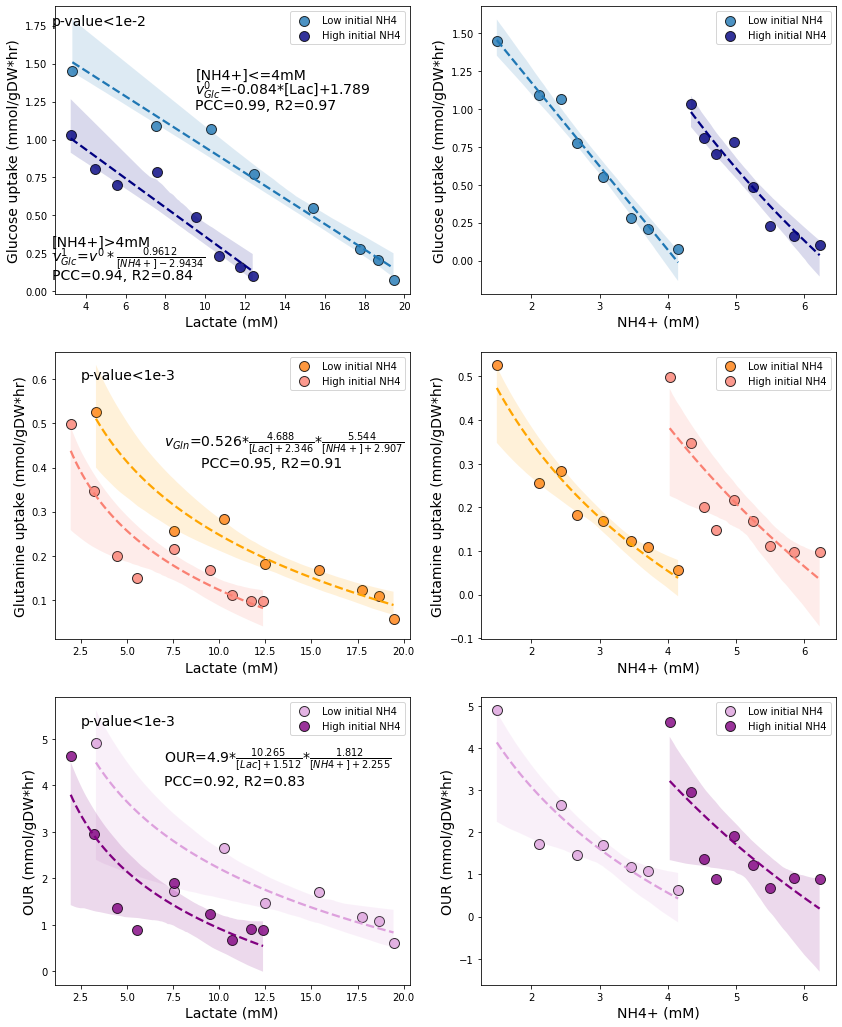

In [41]:
fig,axs=plt.subplots(3,2,figsize=(14,18))
sns.regplot( x=approx_low.Lac_conc, y=-1*approx_low.Glucose_rate,line_kws={'ls':'--'},
           scatter_kws={'s':100,'edgecolor':'black','color':'tab:blue'},label='Low initial NH4',ax=axs[0][0])
sns.regplot( x=approx_high.Lac_conc[1:], y=-1*approx_high.Glucose_rate[1:],line_kws={'ls':'--','color':'navy'},
           scatter_kws={'s':100,'edgecolor':'black','color':'navy'},label='High initial NH4',ax=axs[0][0])
axs[0][0].set_xlabel('Lactate (mM)',fontsize=14); axs[0][0].set_ylabel('Glucose uptake (mmol/gDW*hr)',fontsize=14);
axs[0][0].text(9.5,1.2,s='PCC=0.99, R2=0.97',fontsize=14)
axs[0][0].text(9.5,1.3,s='$v^{0}_{Glc}$=-0.084*[Lac]+1.789',fontsize=14)
axs[0][0].text(9.5,1.4,s='[NH4+]<=4mM',fontsize=14)
axs[0][0].legend()
axs[0][0].text(2.3,0.08,s='PCC=0.94, R2=0.84',fontsize=14)
axs[0][0].text(2.3,0.2,s=r'$v^{1}_{Glc}$=$v^{0}*\frac{0.9612}{[NH4+]-2.9434}$',fontsize=14)
axs[0][0].text(2.3,0.3,s='[NH4+]>4mM',fontsize=14)
axs[0][0].text(2.3,1.75,s='p-value<1e-2',fontsize=14)

sns.regplot( x=approx_low.NH4_conc, y=-1*approx_low.Glucose_rate,line_kws={'ls':'--','color':'tab:blue'},
            scatter_kws={'s':100,'edgecolor':'black','color':'tab:blue'},label='Low initial NH4',ax=axs[0][1])
sns.regplot( x=approx_high.NH4_conc[1:], y=-1*approx_high.Glucose_rate[1:],line_kws={'ls':'--','color':'navy'},logx=True,
            scatter_kws={'s':100,'edgecolor':'black','color':'navy'},label='High initial NH4',ax=axs[0][1])
axs[0][1].legend(); axs[0][1].set_xlabel('NH4+ (mM)',fontsize=14); axs[0][1].set_ylabel('Glucose uptake (mmol/gDW*hr)',fontsize=14);

sns.regplot( x=approx_low.Lac_conc, y=-1*approx_low.Gln_rate,line_kws={'ls':'--','color':'orange'},logx=True,
            scatter_kws={'s':100,'edgecolor':'black','color':'tab:orange'},label='Low initial NH4',ax=axs[1][0])
sns.regplot( x=approx_high.Lac_conc, y=-1*approx_high.Gln_rate,line_kws={'ls':'--','color':'salmon'},logx=True,
            scatter_kws={'s':100,'edgecolor':'black','color':'salmon'},label='High initial NH4',ax=axs[1][0])
axs[1][0].legend(); axs[1][0].set_xlabel('Lactate (mM)',fontsize=14); axs[1][0].set_ylabel('Glutamine uptake (mmol/gDW*hr)',fontsize=14);
axs[1][0].text(9,0.4,s='PCC=0.95, R2=0.91',fontsize=14)
axs[1][0].text(7.0,0.45,s=r'$v_{Gln}$=0.526*$\frac{4.688}{[Lac]+2.346}$*$\frac{5.544}{[NH4+]+2.907}$',fontsize=14)
axs[1][0].text(2.5,0.6,s='p-value<1e-3',fontsize=14)

sns.regplot( x=approx_low.NH4_conc, y=-1*approx_low.Gln_rate,line_kws={'ls':'--','color':'orange'},logx=True,
            scatter_kws={'s':100,'edgecolor':'black','color':'tab:orange'},label='Low initial NH4',ax=axs[1][1])
sns.regplot( x=approx_high.NH4_conc, y=-1*approx_high.Gln_rate,line_kws={'ls':'--','color':'salmon'},logx=True,
            scatter_kws={'s':100,'edgecolor':'black','color':'salmon'},label='High initial NH4',ax=axs[1][1])
axs[1][1].legend(); axs[1][1].set_xlabel('NH4+ (mM)',fontsize=14); axs[1][1].set_ylabel('Glutamine uptake (mmol/gDW*hr)',fontsize=14);

sns.regplot( x=approx_low.Lac_conc, y=approx_low.OUR_estimated,line_kws={'ls':'--','color':'plum'},logx=True,
            scatter_kws={'s':100,'edgecolor':'black','color':'plum'},label='Low initial NH4',ax=axs[2][0])
sns.regplot( x=approx_high.Lac_conc, y=approx_high.OUR_estimated,line_kws={'ls':'--','color':'purple'},logx=True,
            scatter_kws={'s':100,'edgecolor':'black','color':'purple'},label='High initial NH4',ax=axs[2][0])
axs[2][0].legend(); axs[2][0].set_xlabel('Lactate (mM)',fontsize=14); axs[2][0].set_ylabel('OUR (mmol/gDW*hr)',fontsize=14);
axs[2][0].text(7.0,4.0,s='PCC=0.92, R2=0.83',fontsize=14)
axs[2][0].text(7.0,4.5,s=r'OUR=4.9*$\frac{10.265}{[Lac]+1.512}$*$\frac{1.812}{[NH4+]+2.255}$',fontsize=14)
axs[2][0].text(2.5,5.3,s='p-value<1e-3',fontsize=14)

sns.regplot( x=approx_low.NH4_conc, y=approx_low.OUR_estimated,line_kws={'ls':'--','color':'plum'},logx=True,
            scatter_kws={'s':100,'edgecolor':'black','color':'plum'},label='Low initial NH4',ax=axs[2][1])
sns.regplot( x=approx_high.NH4_conc, y=approx_high.OUR_estimated,line_kws={'ls':'--','color':'purple'},logx=True,
            scatter_kws={'s':100,'edgecolor':'black','color':'purple'},label='High initial NH4',ax=axs[2][1])
axs[2][1].legend(); axs[2][1].set_xlabel('NH4+ (mM)',fontsize=14); axs[2][1].set_ylabel('OUR (mmol/gDW*hr)',fontsize=14);
# plt.savefig('../../Figures/LacNH4_inhibition_CNO.svg',format='svg',dpi=150)